In [1]:
import torch
import torch.nn as nn
from networks import DynamicUNet, LearnableScaleDynamicUNet
from networks import dice_score

device = "cuda" if torch.cuda.is_available() else "cpu"

#network = DynamicUNet(1, 2, [128, 256, 512], [128, 128, 64]).to(device)
network = LearnableScaleDynamicUNet(1, 2, [128, 256, 512], 8, [(64, 4), (32, 2), (16, 1)]).to(device)

In [2]:
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
import cv2 as cv
import os
import numpy as np
import re
import albumentations as A

class SegmentationDataset(Dataset):
    def __init__(self, ids, patch_folder="./segmentation/patches", mask_folder="./segmentation/masks", scale=1, augmentation=False):
        self.ids = ids
        self.mask_folder = mask_folder
        self.patch_folder = patch_folder
        self.scale = scale
        self.augmentation = A.Compose([ 
            A.GaussNoise((0.01, 0.05)), 
            A.HorizontalFlip()
        ]) if augmentation else lambda image=None, mask=None: {"image":image, "mask":mask}
    def __len__(self):
        return len(self.ids)
    def __getitem__(self, index):
        patch_path = os.path.join(self.patch_folder, "org_{}.bmp".format(self.ids[index]))
        mask_path = os.path.join(self.mask_folder, "mask_{}.bmp".format(self.ids[index]))

        patch = cv.imread(patch_path, cv.IMREAD_GRAYSCALE)/255.0
        #patch = np.expand_dims(cv.resize(patch, None, fx=self.scale, fy=self.scale), 0)
        mask = cv.imread(mask_path, cv.IMREAD_GRAYSCALE)

        res = self.augmentation(image=patch, mask=mask)
        patch, mask = res["image"], res["mask"]
        patch = np.expand_dims(patch, 0)
        mask = cv.resize(mask, None, fx=self.scale, fy=self.scale, interpolation=cv.INTER_NEAREST)

        return torch.tensor(patch, dtype=torch.float), torch.tensor(mask, dtype=torch.long)

ids = [ re.findall("[0-9]+", name)[0] for name in os.listdir("./segmentation/patches") ]

train, test = train_test_split(ids, test_size=40)

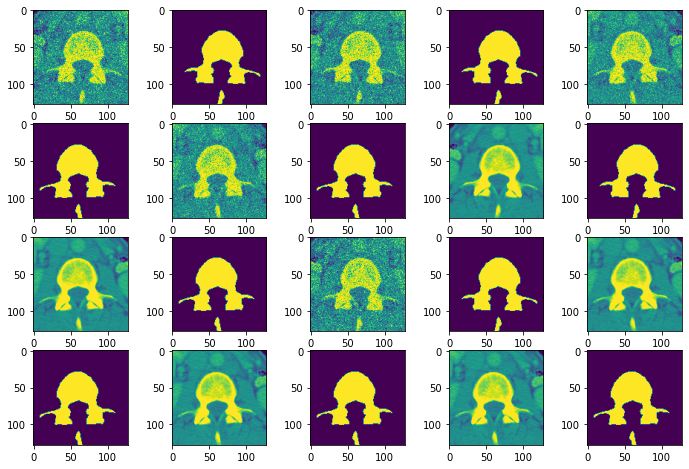

In [3]:
import matplotlib.pyplot as plt

train_dataset = SegmentationDataset(train, scale=1, augmentation=True)

plt.subplots(4, 5, figsize=(12,8))
for i in range(10):
    im = train_dataset[0]
    plt.subplot(4, 5, i*2+1)
    plt.imshow(im[0].squeeze())
    plt.subplot(4, 5, i*2+2)
    plt.imshow(im[1].squeeze())
plt.show()

In [4]:
learning_rate = 1e-4
batch_size = 10

optimizer = torch.optim.Adam(network.parameters(), lr=learning_rate)

train_loss_fn = nn.CrossEntropyLoss()
test_loss_fn = nn.CrossEntropyLoss(reduction="sum")

plateau_window = 5  # Detect plateau if training doesn't progress after num epochs
# plateau_lambda = 0.01 # Detect plateau if difference between current and best is less than lambda

scales = [1/8, 1/4, 1/2, 1]

losses = [ [] for _ in scales ]
dice_scores = [ [] for _ in scales ]

for i, scale in enumerate(scales):
    breakthrough = 999
    since = 0
    side = 128 * scale

    train_dataset = SegmentationDataset(train, scale=scale, augmentation=True)
    test_dataset = SegmentationDataset(test, scale=scale)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    while since != plateau_window:
        # Training
        for X, y in train_loader:
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            x_hat = network(X)
            loss = train_loss_fn(x_hat, y)
            loss.backward()
            optimizer.step()

        # Testing
        with torch.no_grad():
            loss = 0
            dice_score_ = 0
            for X, y in test_loader:
                X, y = X.to(device,), y.to(device)
                x_hat = network(X)
                loss += test_loss_fn(x_hat, y).item()
                dice_score_ += dice_score(x_hat.cpu(), y.cpu(), reduction="sum")
            loss = loss / (len(test_dataset) * side * side ) 
            dice_score_ = dice_score_ / len(test_dataset)
            dice_scores[i].append(dice_score_)
            since += 1
            if loss < breakthrough:
                breakthrough = loss
                since=0
            print("Loss:", loss, "Dice score:", dice_score_)
            losses[i].append(loss)
    print("Epoch ended")
    network.use_higher_layer()

Loss: 0.3862963020801544 Dice score: 0.7591720461845398
Loss: 0.26719739437103274 Dice score: 0.8597919702529907
Loss: 0.21558988988399505 Dice score: 0.8826189756393432
Loss: 0.1879492849111557 Dice score: 0.8971041679382324
Loss: 0.172230327129364 Dice score: 0.9044625759124756
Loss: 0.1623438835144043 Dice score: 0.9084535837173462
Loss: 0.1529820442199707 Dice score: 0.917105770111084
Loss: 0.1470475196838379 Dice score: 0.9127275705337524
Loss: 0.14186746180057525 Dice score: 0.9196813583374024
Loss: 0.1407755047082901 Dice score: 0.9193138122558594
Loss: 0.13428080976009368 Dice score: 0.9183897018432617
Loss: 0.13201796710491182 Dice score: 0.9234593868255615
Loss: 0.13431868255138396 Dice score: 0.920465636253357
Loss: 0.12734127938747405 Dice score: 0.9254942417144776
Loss: 0.12422361671924591 Dice score: 0.9247804880142212
Loss: 0.1261998414993286 Dice score: 0.9249202013015747
Loss: 0.12092822194099426 Dice score: 0.9263396501541138
Loss: 0.12015876471996308 Dice score: 0.92

KeyboardInterrupt: 

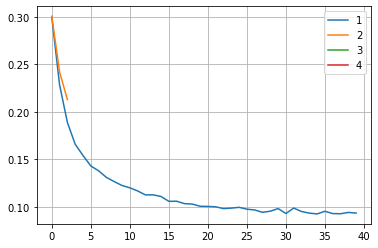

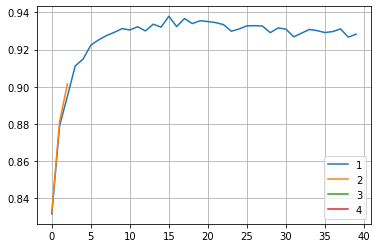

In [5]:
import matplotlib.pyplot as plt

plt.figure()
for loss in losses:
    plt.plot(loss)
plt.legend([1,2,3,4])
plt.grid()
plt.show()

plt.figure()
for dice in dice_scores:
    plt.plot(dice)
plt.legend([1,2,3,4])
plt.grid()
plt.show()

In [ ]:
dice_scores[2]

In [8]:
from torchviz import make_dot

val = network(torch.randn((1, 1, 128, 128)).cuda()).cpu()

make_dot(val.sum(), params=dict(list(network.named_parameters()))).render("torchviz3", format="png")

'torchviz3.png'

In [ ]:

# temp_ = network.additional_mapper_classifiers[-2]["mapper"](torch.randn((5, 1, 128, 128)))

# add_down_ = network.additional_downscale[-2](temp_)
# downscaled_ = network.downscale(add_down_)

# #-----------------------------------#

# # temp = network.additional_mapper_classifiers[-1]["mapper"](torch.randn((5, 1, 64, 64)))

# add_down = network.additional_downscale[-1](downscaled_)
# downscaled = network.downscale(add_down)

# y_hat = network.base_unet(downscaled)

# upscaled = network.additional_upscale[-1]["upsample_conv"](y_hat)

# sth = torch.cat([upscaled, add_down], dim=1)

# res = network.additional_upscale[-1]["conv_cell"](sth)

# # res = network.additional_mapper_classifiers[-1]["classifier"](res)

# #-----------------------------------#

# upscaled = network.additional_upscale[-2]["upsample_conv"](res)

# sth = torch.cat([upscaled, add_down_], dim=1)

# res = network.additional_upscale[-2]["conv_cell"](sth)

# res = network.additional_mapper_classifiers[-2]["classifier"](res)


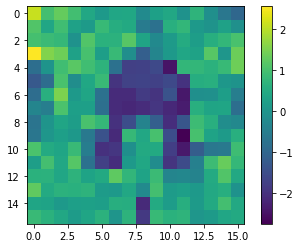

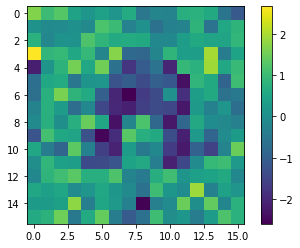

In [6]:
slice = 0
im = train_dataset[0]

plt.imshow(network.base_mapper_classifier["mapper"](im[0].unsqueeze(0).to(device)).detach().squeeze().cpu().numpy()[slice])
plt.colorbar()
plt.show()
plt.imshow(network.base_mapper_classifier["mapper"].conv_layer(im[0].unsqueeze(0).to(device)).detach().squeeze().cpu().numpy()[slice])
plt.colorbar()
plt.show()

In [2]:
import networks as n 
import torch

test = torch.randn(5, 1, 128, 128)

layer = n.ScaleAttentionBlock(1, 10, 4, 128)

layer(test).shape

torch.Size([5, 10, 32, 32])

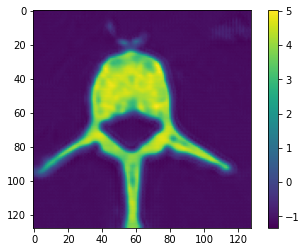

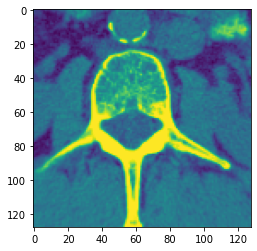

In [9]:
plt.imshow(network(train_dataset[0][0].unsqueeze(0).to(device)).detach().squeeze().cpu().numpy()[1])
plt.colorbar()
plt.show()
plt.imshow(train_dataset[0][0].squeeze())
plt.show()

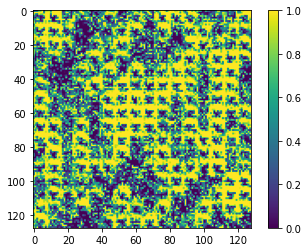

In [12]:
# Debug dd

image = torch.randn(1, 1, 128, 128).to(device).requires_grad_(True)
epochs = 50
lr = 0.1

network.use_layers(0)
network.requires_grad_(False)

for epoch in range(epochs):
    res = network.base_mapper_classifier["mapper"].conv_layer(image)[0]
    grad = (res[2]**2).mean()
    grad.backward()
    with torch.no_grad():
        gradient = torch.conv2d(image.grad, torch.ones(1, 1, 5, 5).to(device), None, padding=2 ) 
        gradient = gradient / (gradient.max() - gradient.min())
        image += gradient * lr
        image.clip_(0.0, 1.0)
    image.grad.zero_()


plt.imshow(image.detach().squeeze().cpu().numpy())
plt.colorbar()

In [11]:
import torch
import torch.nn as nn

layer = nn.MultiheadAttention(10, 1, batch_first=True)

query = torch.randn(1, 5, 10)
key = torch.randn(1, 8, 10)
value = torch.randn(1, 8, 10)

layer(query, key, value)[0].size()

torch.Size([1, 5, 10])

In [20]:
fun = lambda x=None, y=None: x*y
fun(6, 9)

54